In [4]:
#computes sliding window classification accuracy for orofacial movements, single phonemes, and single words for all 4
#arrays (Fig 1e)
baseDir = '/oak/stanford/groups/henderj/fwillett/speechPaperRelease_08_20/'

In [5]:
import scipy.io

phonemesDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.26_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_orofacial.mat')
fiftyWordDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.05.03_fiftyWordSet.mat')
allDatasets = [orofacialDat, phonemesDat, fiftyWordDat]

In [6]:
#mean-subtract within block
import numpy as np
def meanSubtract(dat):
    dat['feat'] = dat['tx2'].astype(np.float32)    
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat

In [7]:
#mean subtraction
from analysis import unscrambleChans, triggeredAvg
for x in range(len(allDatasets)):
    allDatasets[x] = meanSubtract(allDatasets[x])
    allDatasets[x]['feat'][:,0:128] = unscrambleChans(allDatasets[x]['feat'][:,0:128])
    allDatasets[x]['feat'][:,128:] = unscrambleChans(allDatasets[x]['feat'][:,128:])

In [8]:
dataset_trials = []
for x in range(len(allDatasets)):
    fAvg, fCI, trials_go = triggeredAvg(allDatasets[x]['feat'].astype(np.float32), 
                             allDatasets[x]['goTrialEpochs'][:,0],
                             np.squeeze(allDatasets[x]['trialCues']), [-25,125], smoothSD=4)

    fAvg, fCI, trials_delay = triggeredAvg(allDatasets[x]['feat'].astype(np.float32), 
                             allDatasets[x]['delayTrialEpochs'][:,0],
                             np.squeeze(allDatasets[x]['trialCues']), [0,150], smoothSD=4)
    
    dataset_trials.append([trials_go, trials_delay])

In [9]:
fiftyWordCuesToUse = np.arange(1,51).astype(np.int32)
phonemeCuesToUse = np.array([0,1,3,4,5,6,7,8,9,10,11,12,14,15,16,17,19,20,21,22,23,24,
                      26,27,28,29,30,31,32,33,34,35,36,37,38,39]).astype(np.int32)
oroCuesToUse = np.array([0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                         21,22,23,24,25,26,27,28,29,30,31,32,33]).astype(np.int32)
allCues = [oroCuesToUse, phonemeCuesToUse, fiftyWordCuesToUse]

In [10]:
#get classification accuracy for each window & task (plus 95% CIs computed via bootstrap), this may take a while

from analysis import gnb_loo, bootCI
dataset_results = []
datasetNames = ['phonemes','orofacial','fiftyWords']
trialSetNames = ['go','delay']

for datasetIdx in range(len(allDatasets)):
    print('Processing ' + datasetNames[datasetIdx])
    trialSets = [dataset_trials[datasetIdx][0], dataset_trials[datasetIdx][1]]
    all_results = []

    for trialSetIdx in range(len(trialSets)):
        print('-Processing ' + trialSetNames[trialSetIdx] + '-aligned trials')
        trials_subset = []
        for t in range(len(allCues[datasetIdx])):
            trials_subset.append(trialSets[trialSetIdx][allCues[datasetIdx][t]])

        chanSets = [np.arange(0,64).astype(np.int32), np.arange(64,128).astype(np.int32),
                   np.arange(128,192).astype(np.int32), np.arange(192,256).astype(np.int32)]

        all_vals = []
        for chanSetIdx in range(len(chanSets)):
            print('--Processing channel set ' + str(chanSetIdx+1) + '/4')
            mns = []
            cis = []
            for n in range(0,125,5):   
                y_pred, unroll_y = gnb_loo(trials_subset, [n, n+5], chanSets[chanSetIdx])
                mns.append(np.mean(y_pred==unroll_y))
                cis.append(bootCI(y_pred, unroll_y))

            all_vals.append(np.concatenate([np.array(mns)[:,np.newaxis], np.array(cis)], axis=1))

        all_results.append(all_vals)
    
    dataset_results.append(all_results)
        

Processing phonemes
-Processing go-aligned trials
--Processing channel set 1/4
--Processing channel set 2/4
--Processing channel set 3/4
--Processing channel set 4/4
-Processing delay-aligned trials
--Processing channel set 1/4
--Processing channel set 2/4
--Processing channel set 3/4
--Processing channel set 4/4
Processing orofacial
-Processing go-aligned trials
--Processing channel set 1/4
--Processing channel set 2/4
--Processing channel set 3/4
--Processing channel set 4/4
-Processing delay-aligned trials
--Processing channel set 1/4
--Processing channel set 2/4
--Processing channel set 3/4
--Processing channel set 4/4
Processing fiftyWords
-Processing go-aligned trials
--Processing channel set 1/4
--Processing channel set 2/4
--Processing channel set 3/4
--Processing channel set 4/4
-Processing delay-aligned trials
--Processing channel set 1/4
--Processing channel set 2/4
--Processing channel set 3/4
--Processing channel set 4/4


In [11]:
#get average audio volume envelope
fAvg_phonemes, fCI_phonemes, trials_phonemes = triggeredAvg(phonemesDat['audioEnvelope'].astype(np.float32), 
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), [-25,100], smoothSD=0)
audioPhonemes = np.mean(fAvg_phonemes[:,:,0],axis=0)

fAvg_fiftyWord, fCI_fiftyWord, trials_fiftyWord = triggeredAvg(fiftyWordDat['audioEnvelope'].astype(np.float32), 
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), [-25,100], smoothSD=0)
audioFiftyWord = np.mean(fAvg_fiftyWord[:,:,0],axis=0)

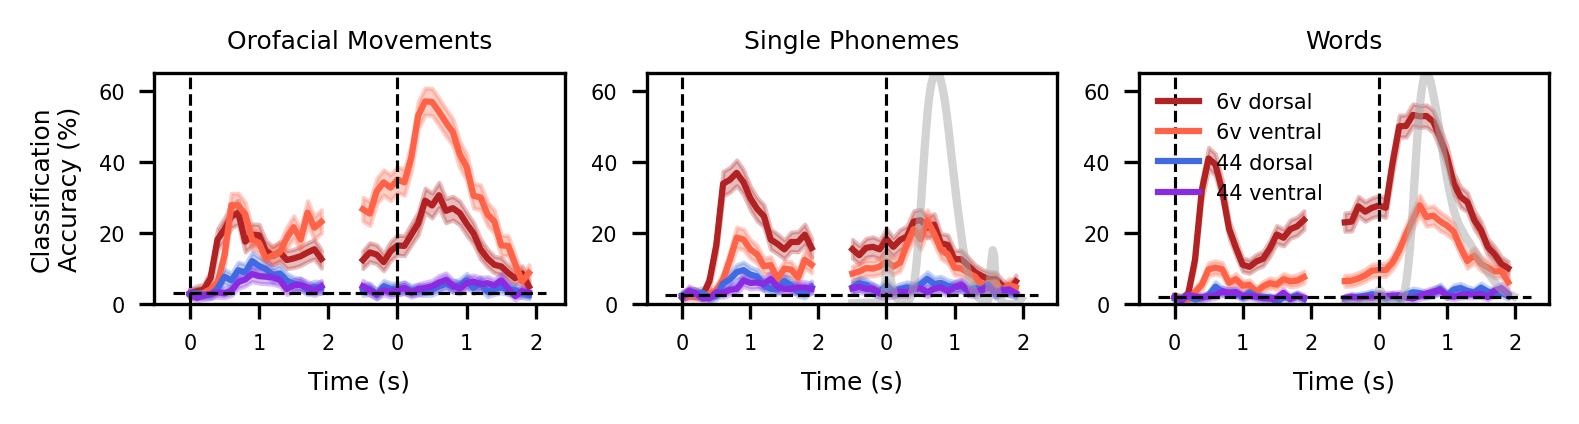

In [12]:
#plot sliding window classification for each array and task
import matplotlib.pyplot as plt
from analysis import plotPreamble
plotPreamble()

chance = [1/33, 1/39, 1/50]
colors = ['firebrick','tomato','royalblue','blueviolet']
taskTitles = ['Orofacial Movements','Single Phonemes','Words']
plt.figure(dpi=300,figsize=(6,1))
for taskIdx in range(len(chance)):
    plt.subplot(1,3,taskIdx+1)
    
    dat_results = np.array(dataset_results)
    goDat = dat_results[taskIdx,0,:,:,:]*100
    delayDat = dat_results[taskIdx,1,:,0:20,:]*100
            
    lHandles = []
    for arrIdx in range(4):
        lHandle = plt.plot(np.arange(0,100,5)*0.02, delayDat[arrIdx,:,0],color=colors[arrIdx])
        lHandles.append(lHandle[0])
        
        plt.fill_between(np.arange(0,100,5)*0.02, 
             delayDat[arrIdx,:,1], 
             delayDat[arrIdx,:,2],alpha=0.3,color=colors[arrIdx])
            
        plt.plot(150*0.02 + np.arange(-25,100,5)*0.02, goDat[arrIdx,:,0],color=colors[arrIdx])
        plt.fill_between(150*0.02 + np.arange(-25,100,5)*0.02, 
             goDat[arrIdx,:,1], 
             goDat[arrIdx,:,2],alpha=0.3,color=colors[arrIdx])
        
    plt.xlabel('Time (s)')
    if taskIdx==0:
        plt.ylabel('Classification\nAccuracy (%)')
    plt.title(taskTitles[taskIdx])
    plt.ylim([0,65])
    if taskIdx==2:
        plt.gca().legend(lHandles, ['6v dorsal','6v ventral','44 dorsal','44 ventral'],frameon=False)
        
    if taskIdx==1:
        speechAudioLine = audioPhonemes.copy()
        speechAudioLine = speechAudioLine - min(speechAudioLine)
        speechAudioLine = speechAudioLine / max(speechAudioLine)
        plt.plot(150*0.02 + np.arange(-25,100)*0.02, speechAudioLine*65,color='darkgray',alpha=0.5,linewidth=2)
    
    if taskIdx==2:
        speechAudioLine = audioFiftyWord.copy()
        speechAudioLine = speechAudioLine - min(speechAudioLine)
        speechAudioLine = speechAudioLine / max(speechAudioLine)
        plt.plot(150*0.02 + np.arange(-25,100)*0.02, speechAudioLine*65,color='darkgray',alpha=0.5,linewidth=2)
            
    plt.xticks(ticks=[0,1,2,3,4,5], labels=['0','1','2','0','1','2'])
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.plot([3,3],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.plot(plt.gca().get_xlim(),[chance[taskIdx]*100, chance[taskIdx]*100],'--k',linewidth=0.75)
    
plt.show()